<a href="https://colab.research.google.com/github/eunoia-code/pneumonia-ipynb/blob/main/Pneumonia_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# !ls "/content/drive/My Drive"

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/dataset-penelitian-kelainan-paru"

masking  original  preprocess


In [5]:
base_path = '/content/drive/My Drive/dataset-penelitian-kelainan-paru/preprocess'

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    vertical_flip=False)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=20,
    zoom_range=0.2,
    vertical_flip=False)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=20,
    zoom_range=0.2,
    vertical_flip=False)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        base_path+'/training',  # this is the target directory
        target_size=(256,256),
        batch_size=32,
        class_mode='categorical')

Found 12132 images belonging to 3 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
        base_path+'/validasi',
        target_size=(256,256),
        batch_size=32,
        class_mode='categorical')

Found 1515 images belonging to 3 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
        base_path+'/testing',
        target_size=(256,256),
        batch_size=32,
        class_mode='categorical')

Found 1515 images belonging to 3 classes.


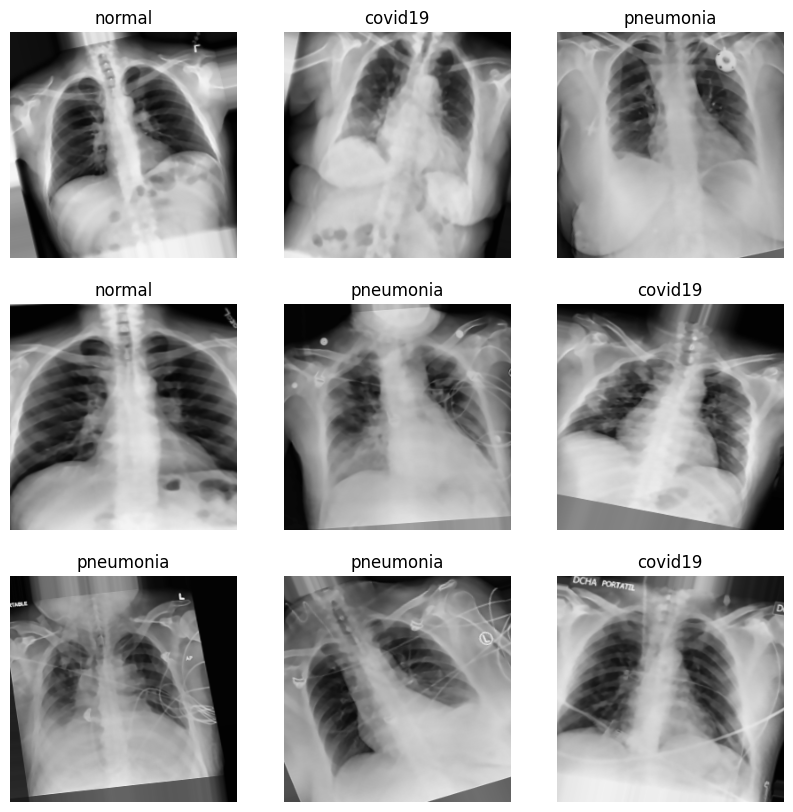

In [ ]:
import matplotlib.pyplot as plt

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        plt.subplot(3, 3, i+1)
        # plt.imshow(np.squeeze(images[i].astype('uint8')), cmap='gray')
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

    break  # Break the loop after the first batch

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
# Load the ResNet152 model
base_model = ResNet152(weights=None, include_top=False, input_shape=(256, 256, 3))

# # Get the configuration of the model
# model_config = base_model.get_config()

# # Print the hyperparameters
# model_config

In [ ]:
num_classes = 3

# Set weight decay rate
weight_decay = 0.001

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Replace num_classes with the number of classes in your dataset

In [ ]:
# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Set learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# from tensorflow.keras.utils import plot_model

# # Draw the model architecture diagram
# plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Initialize checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)

callbacks = [checkpoint, early]
epochs = 10

# Train the model with checkpoint
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // train_generator.batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // validation_generator.batch_size,
      callbacks=callbacks)

Epoch 1/10
379/379 [==============================] - 5688s 15s/step - loss: 1.5073 - accuracy: 0.5073 - val_loss: 2.9303 - val_accuracy: 0.3351
Epoch 2/10
379/379 [==============================] - 383s 1s/step - loss: 1.0382 - accuracy: 0.5893 - val_loss: 2.2144 - val_accuracy: 0.2999
Epoch 3/10
379/379 [==============================] - 376s 991ms/step - loss: 0.9007 - accuracy: 0.6164 - val_loss: 6.8177 - val_accuracy: 0.3205
Epoch 4/10
379/379 [==============================] - 376s 991ms/step - loss: 0.8043 - accuracy: 0.6659 - val_loss: 4.4562 - val_accuracy: 0.2859
Epoch 5/10
379/379 [==============================] - 376s 991ms/step - loss: 0.7202 - accuracy: 0.7130 - val_loss: 3.3086 - val_accuracy: 0.2513
Epoch 6/10
379/379 [==============================] - 381s 1s/step - loss: 0.6806 - accuracy: 0.7310 - val_loss: 1.2786 - val_accuracy: 0.3418
Epoch 7/10
379/379 [==============================] - 376s 990ms/step - loss: 0.6497 - accuracy: 0.7514 - val_loss: 4.8670 - val_ac

In [ ]:
########################################################
########## RUN IF YOU WANT TO LOAD THE MODELS ##########
########################################################
from tensorflow.keras.models import load_model

# Load the model from the checkpoint
model = load_model('best_model.h5')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/2
379/379 [==============================] - 490s 999ms/step - loss: 0.9034 - accuracy: 0.6002 - val_loss: 2.2422 - val_accuracy: 0.3138
Epoch 2/2
379/379 [==============================] - 376s 991ms/step - loss: 0.8088 - accuracy: 0.6541 - val_loss: 2.5653 - val_accuracy: 0.2806


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

48/48 [==============================] - 604s 13s/step - loss: 9.2374 - accuracy: 0.3333
Test accuracy : 0.3333333432674408


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.utils import to_categorical
import numpy as np

# First, we need to gather the true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia', 'Covid-19'])
print(report)

# Calculate AUC-ROC
# AUC-ROC is typically used for binary classification. For multi-class,
# we calculate the average AUC-ROC of each class versus the rest
roc_auc = roc_auc_score(to_categorical(y_true), y_pred, multi_class='ovr')
print('AUC-ROC:', roc_auc)

48/48 [==============================] - 28s 515ms/step
              precision    recall  f1-score   support

      Normal       0.33      1.00      0.50       505
   Pneumonia       0.00      0.00      0.00       505
    Covid-19       0.00      0.00      0.00       505

    accuracy                           0.33      1515
   macro avg       0.11      0.33      0.17      1515
weighted avg       0.11      0.33      0.17      1515

AUC-ROC: 0.4812988922654642
